# Logistic regression: Breast Cancer Data

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from helpers import *
import torch.nn.functional as F


%reload_ext autoreload
%autoreload 2

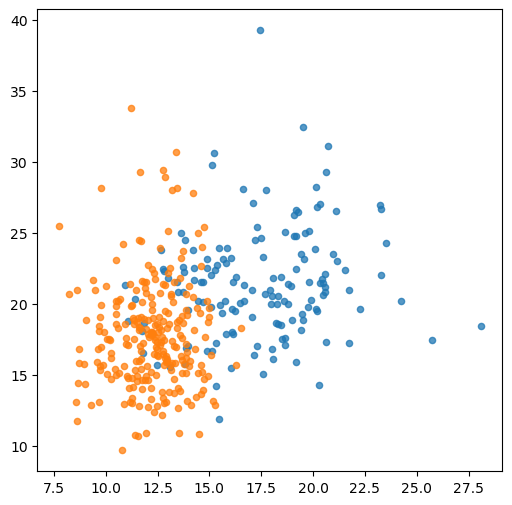

In [278]:
df = pd.read_csv('../data/breast_cancer.csv')
train_idx = pd.read_csv('../data/breast_cancer_train_indices.csv')['train_idx'].to_numpy()

# Select the training data
df_train = df.iloc[train_idx]

# Select the features and the target
X_train = df_train[['radius_mean', 'texture_mean']].to_numpy()
y_train = df_train['diagnosis'].to_numpy()

# Convert the target to 0 and 1
y_train = (y_train == 'M').astype(int)

plot_points(y_train, X_train)

In [279]:
# Convert the data to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [280]:
# Add a column of all ones to X_train
X_train = torch.cat([torch.ones(X_train.shape[0], 1), X_train], dim=1)
X_train.shape

torch.Size([398, 3])

0.25909191370010376

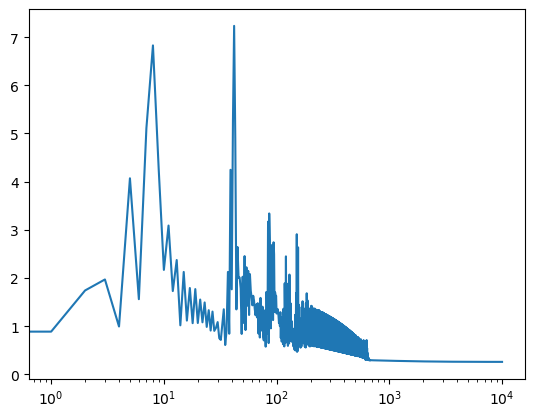

In [281]:
def loss(theta):
    z = X_train @ theta
    return torch.mean(-y_train * z + torch.log(1 + torch.exp(z)))

lr = .04
momentum = 0.9
n_steps = 10000

theta = torch.tensor([0, 0, 0.], requires_grad=True)
loss_hist, theta_list = gd_with_momentum(loss, theta, momentum, lr, n_steps)

# xrange = yrange = (-5, 5) #(-5*snr , 5*snr)
#_ = plot_gd_3d_trajectory(theta_list, loss, xrange, yrange, figsize=(5, 5))
theta_tensor = torch.stack(theta_list).detach().numpy()

plt.plot(loss_hist)
# log log plot
# plt.yscale('log')
plt.xscale('log')
loss_hist[-1]


In [282]:
# plot trajectory of theta_tensor using plotly
plot_gd_3d_trajectory(theta_tensor)

In [283]:
theta_tensor[-10:] # last 10 values of theta

array([[-18.599977  ,   1.0524739 ,   0.15998445],
       [-18.60012   ,   1.0524818 ,   0.15998602],
       [-18.600264  ,   1.0524896 ,   0.15998757],
       [-18.600407  ,   1.0524975 ,   0.15998916],
       [-18.60055   ,   1.0525055 ,   0.15999082],
       [-18.600693  ,   1.0525134 ,   0.15999237],
       [-18.600836  ,   1.0525212 ,   0.15999389],
       [-18.600979  ,   1.0525291 ,   0.15999548],
       [-18.601122  ,   1.0525371 ,   0.15999717],
       [-18.601265  ,   1.052545  ,   0.15999871]], dtype=float32)

In [284]:
theta_hat = theta_tensor[-1]

# no grad
@torch.no_grad()
def model(X):
    return torch.sigmoid(X @ theta_hat) # X: n x d, theta_hat: d

# apply decision rule to training data
pr_hat = model(X_train)

# compute accuracy on training data
acc = torch.mean(((pr_hat > .5) == y_train).float()).item()

print(f'Accuracy on training data: {acc:.2f}')

Accuracy on training data: 0.89


<AxesSubplot: >

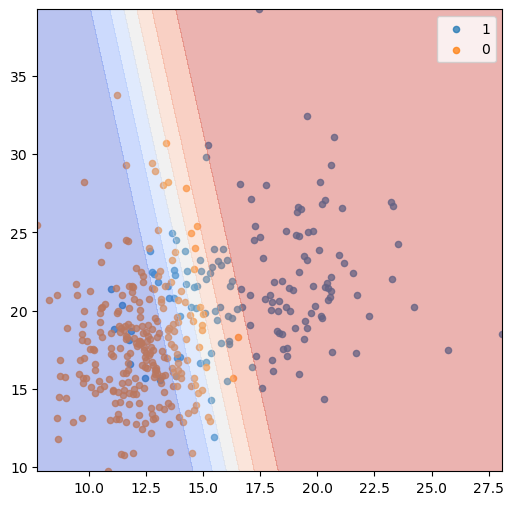

In [285]:
# redefining the model to include the bias term
@torch.no_grad()
def model(X): # X: n x 2
    return torch.sigmoid(X @ theta_hat[1:] + theta_hat[0]) 

plot_decision_bounary(model, X_train[:,1:], y_train)

In [286]:
# perform logistic regression using sklearn package
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, fit_intercept=True).fit(X_train[:, 1:], y_train)
clf.coef_, clf.intercept_


(array([[1.06799968, 0.16545272]]), array([-18.92964985]))

In [287]:
theta_hat = torch.tensor([clf.intercept_[0], clf.coef_[0, 0], clf.coef_[0, 1]], requires_grad=False)
print(theta_hat)

tensor([-18.9296,   1.0680,   0.1655], dtype=torch.float64)
